# FIUFIP: Que No Se Escape Nadie

## Introducción

Este trabajo consiste en analizar una serie de datos recoletados por la agencia gubernamental de recaudación de impuestos *FIUFIP*.

Buscaremos entender como se relacionan estos datos y determinar un metodo de si una persona tiene **altos ingresos** o **bajos ingresos** a partir de los datos recibidos, que consisten en una serie de atributos de la persona que la agencia fue llenando y catalogando a la persona como de altos ingresos o no.



## Objetivos

**Tarea**: explicar qué conclusiones se pueden llegar a partir de analizar los datos recolectados

* Saber cómo entender cada uno de los datos
* Saber cómo se relacionan entre sí 
* Saber si se puede sacar alguna conclusión o descubrir un patrón a partir de estos

**Adicionalmente**

* Saber cuáles son los factores más importantes que determinan si un usuario **tiene altos** o **bajos ingresos** {*varible_target*}.

**Baseline**: código simple 

* intente predecir el target (si el usuario tiene **altos ingresos** o **bajos ingresos**).




## Carga de librerias y dataset

In [1]:
from collections import Counter 
import requests 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

Tambien leemos el dataset, que está en formato CSV desde Google Drive.

In [2]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("fiufip_dataset.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
        


In [3]:
df = pd.read_csv("fiufip_dataset.csv")

# Ser contribuyente y proveer todos los datos a FIUFIP puede volverse complicado ¿Hay datos que falten en el dataset provisto?


Por ser una base de datos de la agencia FIUFIP, es posible que algunos contribuyentes hayan decido no responder o responder erroneamente a la hora de exponer sus datos personales. Esto puede llevar a que haya datos faltantes. Veamos si hay datos faltantes y ya que estamos visualicemos todas las features provistas en el dataset

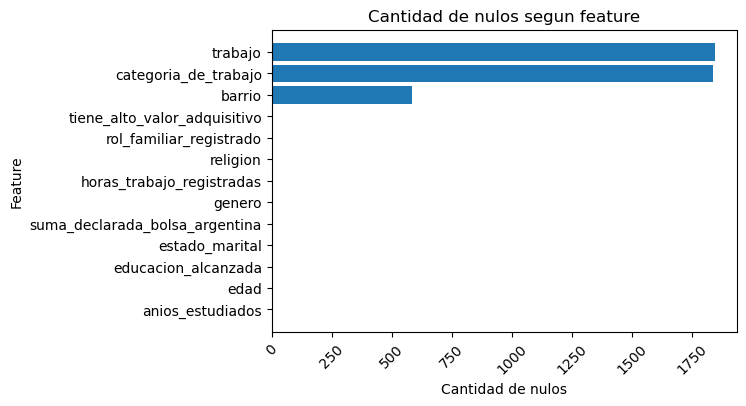

In [4]:
plt.figure(dpi = 100)
df.rename(columns={'ganancia_perdida_declarada_bolsa_argentina':'suma_declarada_bolsa_argentina'},inplace=True)
nulos = df.isnull().sum().sort_values(ascending = True)


y_pos = np.arange(len(nulos.index))
plt.barh(y_pos, nulos.values, align='center')
plt.yticks(y_pos, nulos.index)
plt.ylabel('Feature')
plt.xlabel('Cantidad de nulos')
plt.xticks(rotation = 45)
plt.title('Cantidad de nulos segun feature')
plt.show()

Se pueden observar todas las features provistas. En particular solo tres de ellas presentan valores nulos. Resulta llamativo que los nulos en categoria de trabajo y trabajo sean similiares pero primero veamos sucede con la feature barrio 

## ¿Qué sucede y cómo se distribuye la feature barrio? ¿A qué puede deberse su cantidad de valores nulos?

Veamos la cantidad de posibles opciones de barrio que hay en el dataset

In [5]:
len(df.barrio.value_counts().index)


41

Lo primero a destacar es que hay 41 barrios mientrás que Capital Federal tiene 48, luego los datos faltantes podrían deberse a que no estaban todas las opciones disponibles al momento de obtener los datos. Debido a esto cambiemos el Nan por 'Otro' y veamos la distribución de la feature en cuestión

[]

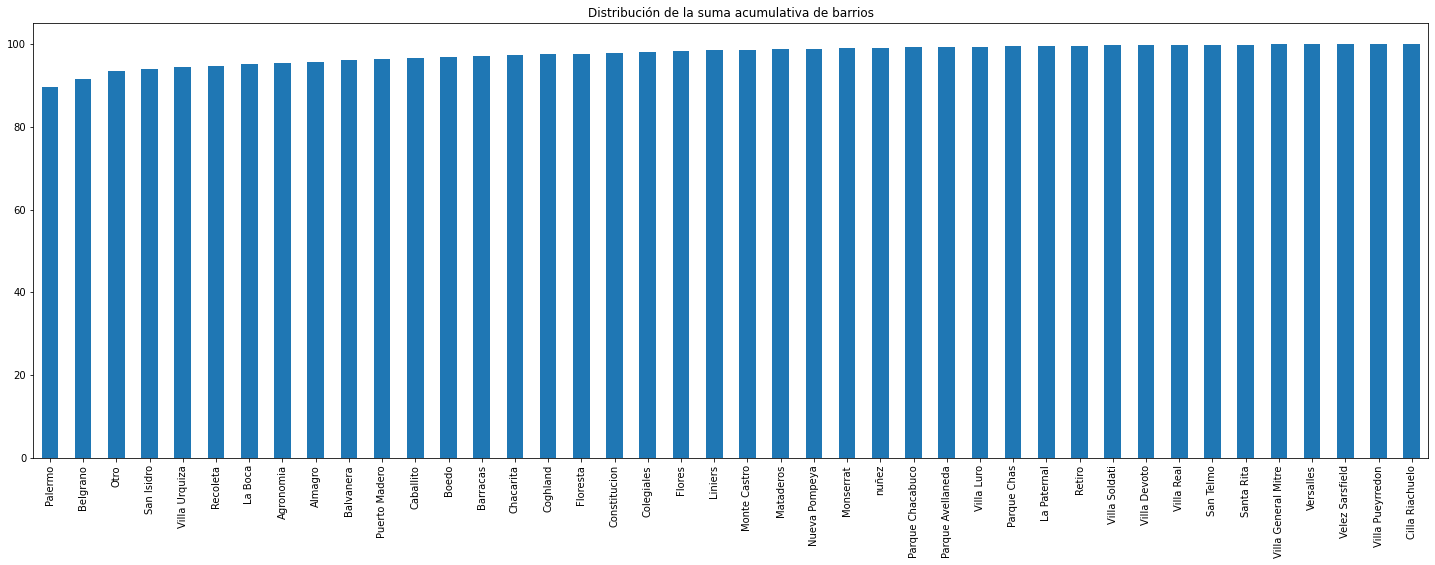

In [6]:
df['barrio'] = df['barrio'].replace(np.nan,'Otro')
barrios = df['barrio'].value_counts(normalize=True,dropna=False) * 100

barrios.cumsum().plot(
   kind='bar', title="Distribución de la suma acumulativa de barrios", figsize=(25, 8)
)
plt.plot()

De este gráfico, podemos observar que casi el 90% de los contribuyentes vive en el barrio de Palermo. Es decir, que se trata de una feature que además de tener una alta cardinaliad, tiene una baja varianza y a priori pareciera dificil poder establecer relaciones con otras variables

## ¿Qué sucede con los valores nulos en las features 'categoría de trabajo' y 'trabajo'? ¿Tiene alguna relación?

Como habiamos mencionado anteriormente, la cantidad de nulos en estas features es de un número parecido. Veamos si existe alguna relación que se pueda observar. En primer lugar veamos la feature categoria de trabajo

In [7]:
df['categoria_de_trabajo'].value_counts(dropna=False)

relacion_de_dependencia    22696
monotibutista               2541
empleado_municipal          2093
NaN                         1836
empleado_provincial         1298
responsable_inscripto       1116
empleadao_estatal            960
trabajo_voluntariado          14
sin_trabajo                    7
Name: categoria_de_trabajo, dtype: int64

Remplacemos el Nan por un 'No contesta' para poder entender mejor los datos, ya que estamos hablando de una variable categorica. Por otra parte,   se observa una distinción entre los distintos tipos de empleado público posible. Reasignemolos a una nueva categoria 'empleado_publico' y veamos la distribución de esta feature

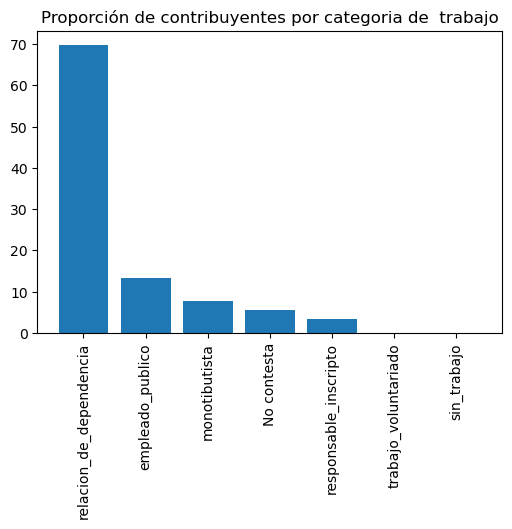

In [8]:
def generalizar_empleados_publicos(categoria):
    if categoria in ['empleado_municipal','empleado_provincial','empleadao_estatal']:
        return 'empleado_publico'
    return categoria
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].replace(np.nan,'No contesta')
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].apply(generalizar_empleados_publicos)
plt.figure(dpi = 100)
cantidad_por_trabajo = df['categoria_de_trabajo'].value_counts(normalize=True) * 100
plt.bar(cantidad_por_trabajo.index,cantidad_por_trabajo.values)
plt.title("Proporción de contribuyentes por categoria de  trabajo")
plt.xticks(rotation = 90)
plt.show()

Vemos que la gran mayoria de los contribuyentes se encuentra trabajando en el sector privado y en particular casi el 70% lo hace en relación de dependencia. Quizás en un futuro esta información nos sea útil, pero por el momento sigamos adelante. Veamos ahora la feature 'trabajo'

In [9]:
df['trabajo'].value_counts(dropna=False)

profesional_especializado    4140
reparador                    4099
directivo_gerente            4066
entretenimiento              3770
ventas                       3650
otros                        3295
inspector                    2002
NaN                          1843
transporte                   1597
limpiador                    1370
sector_primario               994
soporte_tecnico               928
seguridad                     649
servicio_domestico            149
ejercito                        9
Name: trabajo, dtype: int64

Podemos observar que no figura entre las posibles opciones estar desempleado, con lo cual quizas no estaba la opción a la hora de la construcción del dataset. Remplacemos los NaN por 'No contesta' y luego veremos si podemos obtener más información de quienes no contestaron

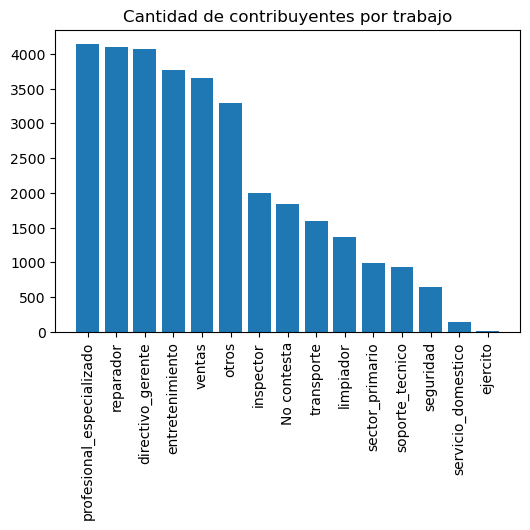

In [10]:
df['trabajo'] = df['trabajo'].replace(np.nan,'No contesta')
plt.figure(dpi = 100)
cantidad_por_trabajo = df['trabajo'].value_counts()
plt.bar(cantidad_por_trabajo.index,cantidad_por_trabajo.values)
plt.title("Cantidad de contribuyentes por trabajo")
plt.xticks(rotation = 90)
plt.show()

Vemos que hay cinco trabajos predominantes, lo cual por el momento no nos dice mucho

In [11]:
dataset_sin_contestar = df[df['categoria_de_trabajo'] == 'No contesta']
dataset_sin_contestar = dataset_sin_contestar[dataset_sin_contestar['trabajo'] == 'No contesta']
dataset_sin_contestar.shape

(1836, 13)

Se puede ver que trás filtrar el dataset quienes no contestan en la feature 'trabajo', tampoco lo hacen en la feature 'categoria_de_trabajo'. Ahora bien, ¿Se trata esto de un error en la recolección de los datos por parte de nuestra querida agencia? ¿Se tratará de desempleados que erronamente figuran en el dataset? ¿O son desempleados (quizás retirados) que conservan fuentes de ingreso que son gravables? 

## Aquellos de quienes desconocemos su trabajo,  ¿Operan en la bolsa?¿Qué edades tienen? ¿Presentan horas registradas trabajando?

Veamos primero como es la distribución de las edades

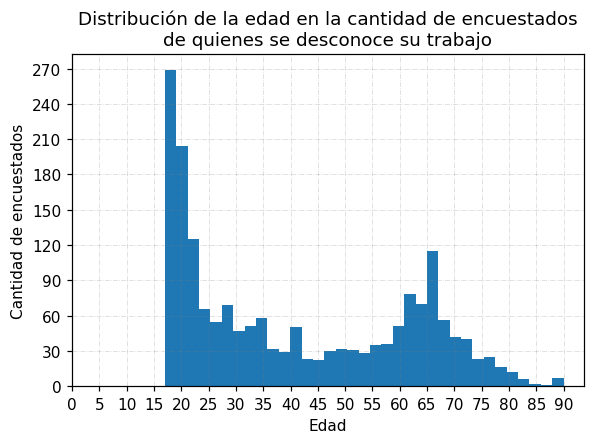

In [12]:
plt.figure(dpi=110)
bins_deseados = int(dataset_sin_contestar.edad.nunique()/2)
plt.hist(dataset_sin_contestar.edad, bins=bins_deseados, label="Edad")

plt.title("Distribución de la edad en la cantidad de encuestados\nde quienes se desconoce su trabajo")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Edad")
plt.xticks(np.arange(0,95, 5))
plt.yticks(np.arange(0,300, 30))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

No resulta llamativo una cierta concentración a partir de aproximadamente contribuyentes mayores a 60 años (pueden ser jubilados con bienes adicionales que sean gravables), pero ¿como se puede explicar la concentración que vemos en los sub 30? Investiguemos un poco más, quizás hemos identificado a genios del trading, que aún así no lograron evadir las garras de la FIUFIP

### Los menores a 30 años, ¿Tiene alta participación en la bolsa?

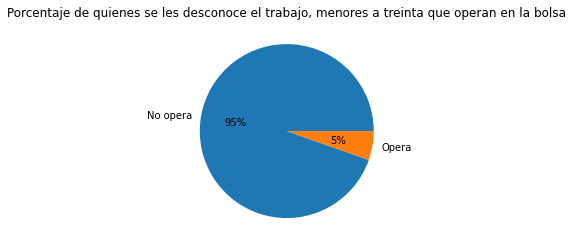

In [13]:
menores_a_treinta = dataset_sin_contestar[dataset_sin_contestar['edad'] <= 30]
porcentaje_que_opera = (menores_a_treinta['suma_declarada_bolsa_argentina'] != 0).value_counts(normalize=True)
porcentaje_que_opera.plot(kind='pie',autopct='%1.0f%%',labels = ['No opera','Opera'])
plt.title('Porcentaje de quienes se les desconoce el trabajo, menores a treinta que operan en la bolsa')
plt.ylabel('')
plt.show()


Bueno, pareciera que no se trata particularmente de genios de las finanzas, o al menos no de gente que tiene interés en comunicarlo. Veamos que sucede con las horas de trabajo registradas

### ¿Como es la distribución de horas trabajadas de estas personas?¿Y si es gente que esta desempleada y figura por error?

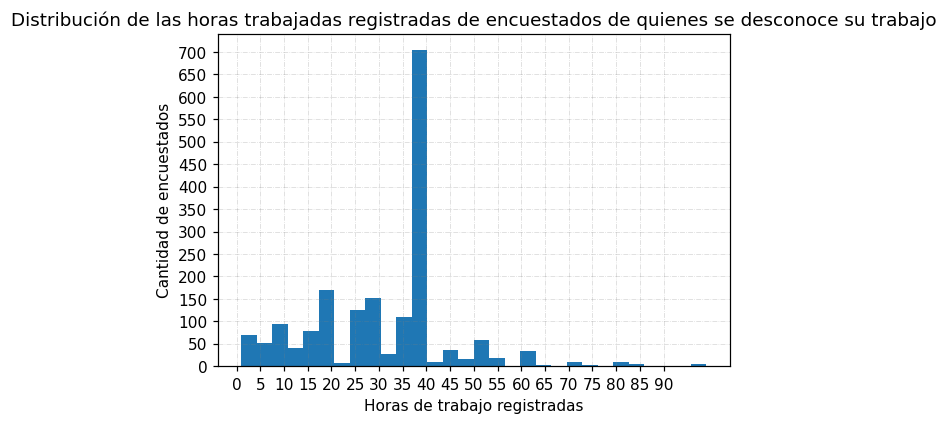

In [14]:
plt.figure(dpi=110)
bins_deseados = int(dataset_sin_contestar.horas_trabajo_registradas.nunique()/2)
plt.hist(dataset_sin_contestar.horas_trabajo_registradas, bins=bins_deseados, label="Edad")

plt.title("Distribución de las horas trabajadas registradas de encuestados de quienes se desconoce su trabajo")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Horas de trabajo registradas")
plt.xticks(np.arange(0,95, 5))
plt.yticks(np.arange(0,750, 50))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

Los datos resultan concluyentes. No parece tratarse de desempleados (a menos que acaben de perder el empleo y estos datos aún no se hayan actualizado) sino más bien gente de la que realmente no se tiene información. Habrá que mejorar la recolección de datos hecha por FIUFIP. 

# Se puede mentir con la edad en las redes, en persona, pero ... ¿Y a la FIUFIP?

Resulta de interés observar la distribución de edades de los contribuyentes. Reagrupemos en rangos y observemos

Antes de analizar, nos preguntamos por los missings, chequemos las variables numericas del a misma

In [15]:
(df.edad < 10).any()

False

Es decir, no hay ninguna edad incongruente.

**Duda de remplazar por histograma**

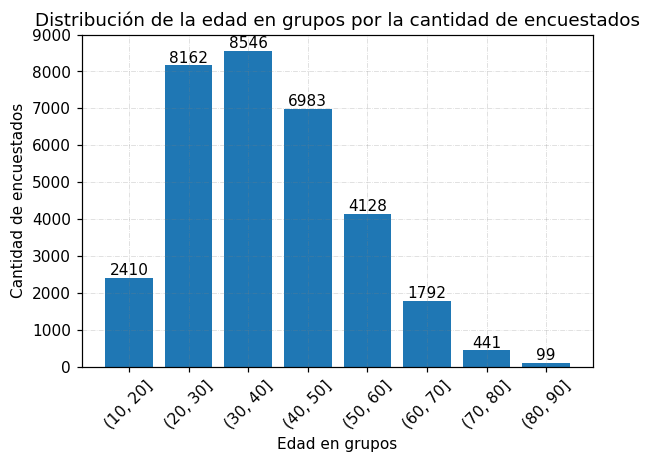

In [16]:
fig, ax = plt.subplots(dpi=110)
    
rango_edades =  np.arange(10,100,10)
cantidad_en_rango = pd.Series(pd.cut(df['edad'], bins = rango_edades).value_counts()).sort_index()

ploted = plt.bar(cantidad_en_rango.index.astype(str), cantidad_en_rango.values)

for rect in ploted:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height,
            '%d' % int(height),
            ha='center', va='bottom')

plt.title("Distribución de la edad en grupos por la cantidad de encuestados")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Edad en grupos")
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.tick_params('x',labelrotation=45)
plt.yticks(np.arange(0,9500, 1000))
plt.show()

Justo como lo sospechabamos, hay una mayor cantidad de contribuyentes en el rango de los 20 años a los 50 años. Era esperable, se trata de los años donde la gran mayoria de las personas realiza su vida profesional. 

## Edad y horas trabajadas ¿Una evidente relación?

### ¿Cuanto trabaja la gente en general?

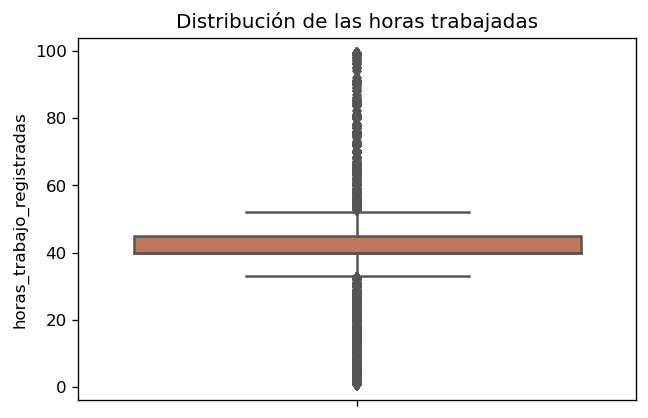

In [17]:
plt.figure(dpi=120)
plt.title("Distribución de las horas trabajadas")
sns.boxplot(
    data=df,
    y='horas_trabajo_registradas',
    palette=['#D17049', "#89D15E"],
)

plt.show()

Es horroroso y seguro esta mal, pero estoy medio hasta las pelotas de hacer histogramas

**HACER HISTOGRAMA**

### Ahora si, ¿Se trabaja menos con el paso del tiempo?

La lógica indica que con el paso de los años, se tiende a trabajar menos. O al menos esperamos que sea asi. Veamos si hallamos una relación

<ipython-input-18-358da99d9b09>:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(pf['horas_trabajadas_promedio'])


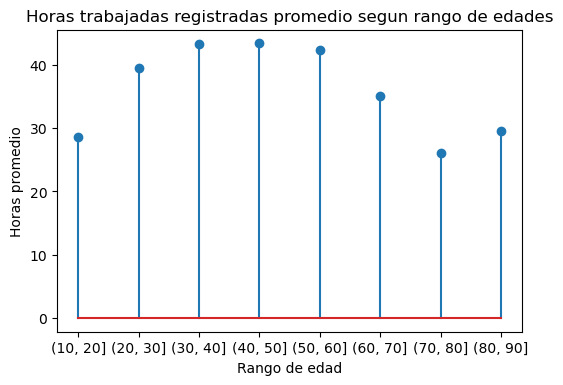

In [18]:
rango_edades =  np.arange(10,100,10)
pf = df
pf['rango'] = pd.Series(pd.cut(pf['edad'], bins = rango_edades))
pf = pf.groupby('rango').agg(list)
pf['horas_trabajadas_promedio'] = pf['horas_trabajo_registradas'].apply(np.mean)

plt.figure(dpi=100)
plt.stem(pf['horas_trabajadas_promedio'])
plt.title('Horas trabajadas registradas promedio segun rango de edades')
plt.xticks(np.arange(0,8,1),pf.index)
plt.xlabel('Rango de edad')
plt.ylabel('Horas promedio')

plt.show()


Nuestra sospecha fue confirmada, al avanzar la edad, las horas de trabajo promedio tienden a ser menos. Además observamos que los menores a 20 años tambien trabajan menos horas en promedio, probablemente porque muchos pueden estar estudiando y se insertan en el mercado laboral en trabajos de menor carga horaria. Sigamos analizando un poco más...

## ¿Hay un rango de Edades que dé indicios de tener alto valor adquisitivo?

Bueno, llegamos a quizás la feature más importante y de la que hablaremos mucho. Hagamos una breve introducción

### ¿Que porcentaje de contribuyenes califican como de altos y bajos ingresos?

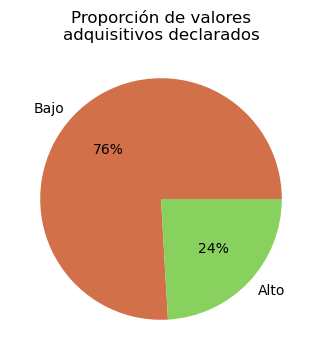

In [19]:
plt.figure(dpi=100)
valor_adquisitivo = df.tiene_alto_valor_adquisitivo.value_counts()
valor_adquisitivo.plot(kind='pie',labels= ['Bajo', 'Alto'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.title("Proporción de valores\nadquisitivos declarados")
plt.ylabel('')
plt.show()

Vemos que solo el 24% de los contribuyentes califica como de altos ingresos. Este dato sera importante ya que muchas veces dividiremos a los contribuyentes segun su categoria de ingresos. Pero no nos desviemos aún

### Retomando... ¿Influye la edad en tener altos o bajos ingresos?

**Comentario**

#### OPCION 1: mantener barplot pero mostrar torta para indagar sobre ese rango..

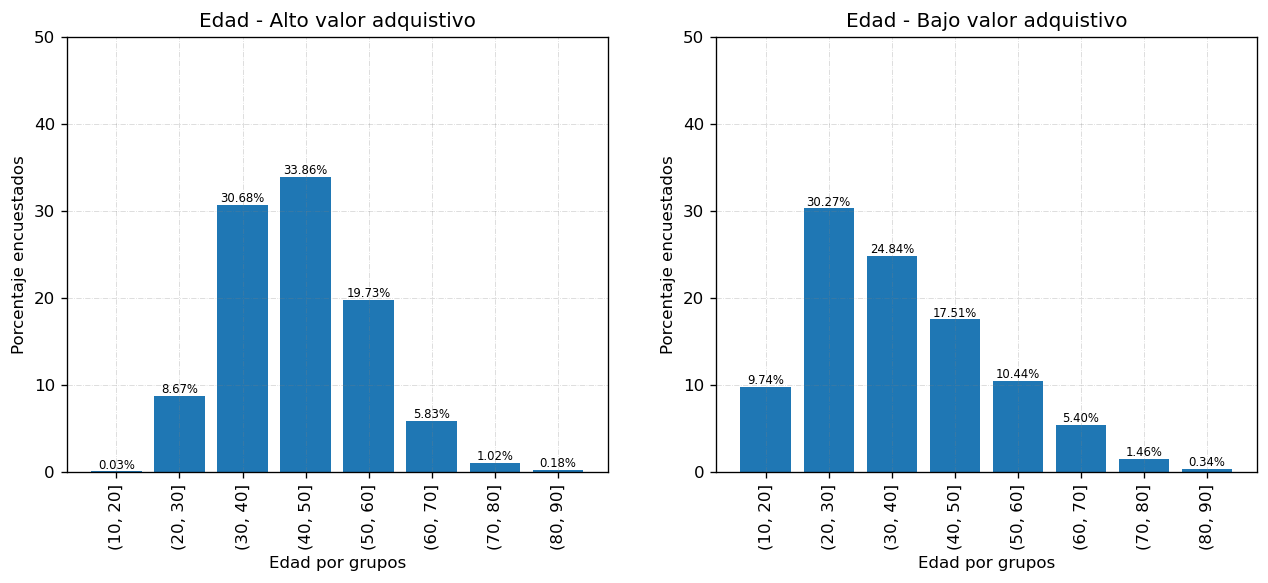

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=120)

df_alto_valor = df[df.tiene_alto_valor_adquisitivo == 1]
df_bajo_valor = df[df.tiene_alto_valor_adquisitivo == 0]

rango_edades =  np.arange(10,100,10)
cantidad_Altos_en_rango = pd.Series(pd.cut(df_alto_valor['edad'], bins = rango_edades).value_counts(normalize=True)*100).sort_index()
cantidad_Bajos_en_rango = pd.Series(pd.cut(df_bajo_valor['edad'], bins = rango_edades).value_counts(normalize=True)*100).sort_index()

ploted = axes[0].bar(cantidad_Altos_en_rango.index.astype(str), cantidad_Altos_en_rango.values)
ploted2 = axes[1].bar(cantidad_Bajos_en_rango.index.astype(str), cantidad_Bajos_en_rango.values)

for plot in [(ploted,axes[0]), (ploted2,axes[1])]:
    for rect in plot[0]:
        height = rect.get_height()
        plot[1].text(rect.get_x() + rect.get_width()/2., height, 
                '%0.2f%%' % float(height),
                ha='center', va='bottom', size=7)
        
    plot[1].grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
    plot[1].tick_params('x',labelrotation=90)
    plot[1].set_ylabel("Porcentaje encuestados")
    plot[1].set_xlabel("Edad por grupos")
    plot[1].set_yticks(np.arange(0,60, 10))
    

axes[0].set_title("Edad - Alto valor adquistivo")
axes[1].set_title("Edad - Bajo valor adquistivo")

plt.show()


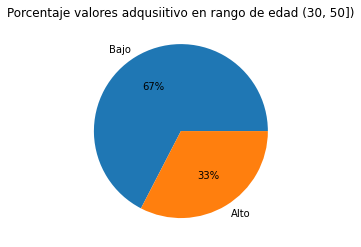

In [21]:
df_range = df[(df['edad'] > 30) & (df['edad'] <= 50)]
df_range.tiene_alto_valor_adquisitivo.value_counts().plot(kind='pie',autopct='%1.0f%%',labels = ['Bajo','Alto'])
plt.title('Porcentaje valores adqusiitivo en rango de edad (30, 50])')
plt.ylabel('')
plt.show()


#### OPCION 2: mostrar 1 solo barplot, pero seria lo mismo que lo anterior.... me gusta opcion 1, dejo igual la 2 acá..

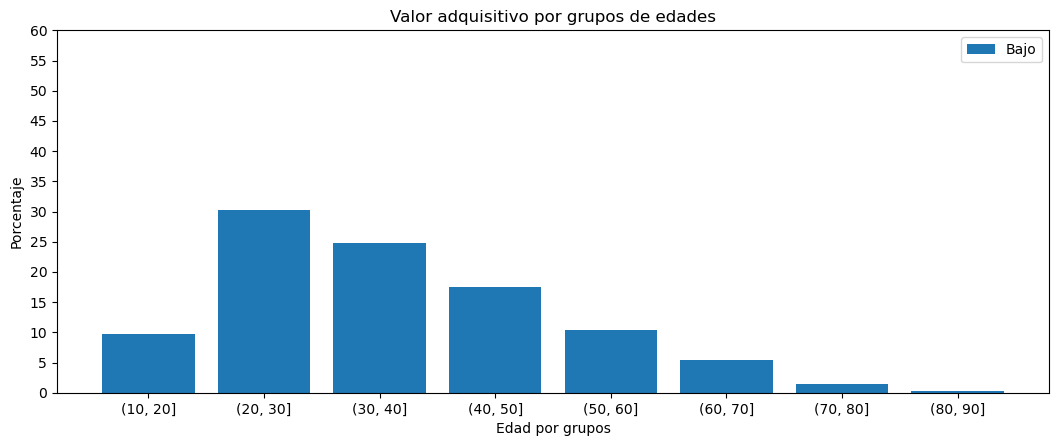

In [71]:
fig, ax = plt.subplots(figsize=[6.4 * 2, 4.8], dpi=100)

df_alto_valor = df[(df.tiene_alto_valor_adquisitivo == 1)]
df_bajo_valor = df[(df.tiene_alto_valor_adquisitivo == 0)]

rango_edades =  np.arange(10,100,10)
cantidad_Altos_en_rango = pd.Series(pd.cut(df_alto_valor['edad'], bins = rango_edades).value_counts(normalize=True)*100).sort_index()
cantidad_Bajos_en_rango = pd.Series(pd.cut(df_bajo_valor['edad'], bins = rango_edades).value_counts(normalize=True)*100).sort_index()

#ploted_altos = ax.bar(cantidad_Altos_en_rango.index.astype(str), cantidad_Altos_en_rango.values, label = 'Alto')
ploted_bajos = ax.bar(cantidad_Bajos_en_rango.index.astype(str), cantidad_Bajos_en_rango.values, label = 'Bajo')#, bottom = cantidad_Altos_en_rango.values)
ax.set_yticks(np.arange(0,65, 5))

ax.set_title("Valor adquisitivo por grupos de edades")
ax.set_ylabel("Porcentaje")
ax.set_xlabel("Edad por grupos")
ax.legend()

plt.show()


In [72]:
cantidad_Altos_en_rango

(10, 20]     0.025507
(20, 30]     8.672363
(30, 40]    30.684862
(40, 50]    33.860477
(50, 60]    19.729626
(60, 70]     5.828338
(70, 80]     1.020278
(80, 90]     0.178549
Name: edad, dtype: float64

In [ ]:
fig, ax = plt.subplots(dpi=110)
    
rango_edades =  np.arange(10,100,10)
cantidad_en_rango = pd.Series(pd.cut(df['edad'], bins = rango_edades).value_counts()).sort_index()

ploted = plt.bar(cantidad_en_rango.index.astype(str), cantidad_en_rango.values)

for rect in ploted:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height,
            '%d' % int(height),
            ha='center', va='bottom')

plt.title("Distribución de la edad en grupos por la cantidad de encuestados")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Edad en grupos")
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.tick_params('x',labelrotation=45)
plt.yticks(np.arange(0,9500, 1000))
plt.show()

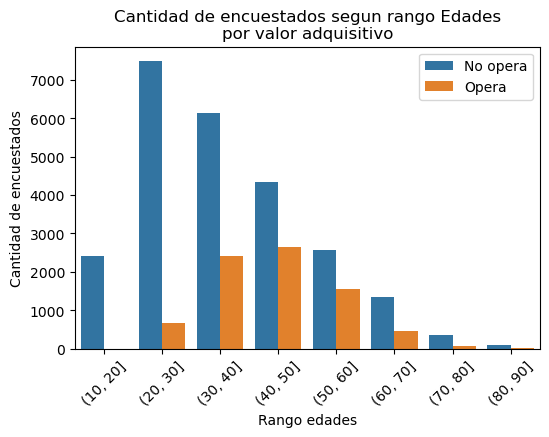

In [91]:
rango_edades =  np.arange(10,100,10)
pf = df
pf['rango'] = pd.Series(pd.cut(pf['edad'], bins = rango_edades))

plt.figure(dpi = (100))
sns.countplot(
   data=pf, x='rango', hue='tiene_alto_valor_adquisitivo'
)

plt.legend(labels=['No opera','Opera'])
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Rango edades")
plt.title("Cantidad de encuestados segun rango Edades\npor valor adquisitivo")
plt.xticks(rotation=45)
plt.show()

plt.show()

In [80]:
rango_edades =  np.arange(10,100,10)
pf = df
pf['rango'] = pd.Series(pd.cut(pf['edad'], bins = rango_edades))
#pf = pf.groupby('rango').agg(list)
pf.rango

0        (30, 40]
1        (40, 50]
2        (30, 40]
3        (50, 60]
4        (20, 30]
           ...   
32556    (20, 30]
32557    (30, 40]
32558    (50, 60]
32559    (20, 30]
32560    (50, 60]
Name: rango, Length: 32561, dtype: category
Categories (8, interval[int64]): [(10, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 80] < (80, 90]]

In [75]:
pf

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,suma_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo,declaro_actividad_en_bolsa,Educacion alcanzada generalizada distinta,Educacion alcanzada generalizada,Anios estudiados generalizada
rango,,,,,,,,,,,,,,,,,
"(10, 20]","[13, 14, 13, 13, 14, 11, 13, 14, 10, 14, 14, 1...","[Palermo, Palermo, Palermo, Otro, Palermo, Pal...","[relacion_de_dependencia, relacion_de_dependen...","[19, 20, 19, 18, 19, 18, 18, 20, 17, 19, 20, 2...","[4_anio, 5_anio, 4_anio, 4_anio, 5_anio, 2_ani...","[sin_matrimonio, sin_matrimonio, matrimonio_mi...","[0, 0, 0, 0, 0, 0, 0, 0, 34095, 0, -1719, 0, 0...","[hombre, hombre, mujer, mujer, hombre, mujer, ...","[40, 44, 25, 30, 32, 22, 30, 40, 32, 35, 28, 2...","[cristianismo, judaismo, cristianismo, cristia...","[con_hijos, con_hijos, casado_a, con_hijos, co...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[reparador, ventas, entretenimiento, otros, pr...","[False, False, False, False, False, False, Fal...","[Secundario - (3,6] grado, Secundario - (3,6] ...","[Secundaria, Secundaria, Secundaria, Secundari...","[(10,15], (10,15], (10,15], (10,15], (10,15], ..."
"(20, 30]","[17, 17, 17, 13, 16, 14, 14, 14, 17, 13, 15, 1...","[Balvanera, Almagro, Palermo, Palermo, Palermo...","[relacion_de_dependencia, empleado_publico, re...","[28, 30, 23, 25, 23, 30, 22, 21, 24, 25, 29, 2...","[universidad_3_anio, universidad_3_anio, unive...","[matrimonio_civil, matrimonio_civil, sin_matri...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5013, 240...","[mujer, hombre, mujer, hombre, hombre, hombre,...","[40, 40, 30, 35, 52, 40, 15, 40, 50, 35, 43, 4...","[judaismo, budismo, cristianismo, cristianismo...","[casado_a, casado_a, con_hijos, con_hijos, sin...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[profesional_especializado, profesional_especi...","[False, False, False, False, False, False, Fal...","[Universitario - [1,3] grado, Universitario - ...","[Universitario, Universitario, Universitario, ...","[(15,20], (15,20], (15,20], (10,15], (15,20], ..."
"(30, 40]","[17, 13, 18, 18, 14, 16, 15, 8, 13, 11, 20, 9,...","[Palermo, Palermo, Palermo, Palermo, Palermo, ...","[empleado_publico, relacion_de_dependencia, re...","[39, 38, 37, 31, 37, 32, 40, 34, 32, 38, 40, 3...","[universidad_3_anio, 4_anio, universidad_4_ani...","[sin_matrimonio, divorciado, matrimonio_civil,...","[2174, 0, 0, 14084, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[hombre, hombre, mujer, mujer, hombre, hombre,...","[40, 40, 40, 50, 80, 50, 40, 45, 40, 50, 60, 4...","[cristianismo, cristianismo, cristianismo, cri...","[sin_familia, sin_familia, casado_a, sin_famil...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[entretenimiento, limpiador, directivo_gerente...","[True, False, False, True, False, False, False...","[Universitario - [1,3] grado, Secundario - (3,...","[Universitario, Secundaria, Universitario, Uni...","[(15,20], (10,15], (15,20], (15,20], (10,15], ..."
"(40, 50]","[17, 9, 17, 18, 11, 13, 17, 11, 16, 13, 18, 15...","[Palermo, Caballito, Palermo, Palermo, Palermo...","[monotibutista, relacion_de_dependencia, relac...","[50, 49, 42, 43, 43, 49, 45, 48, 48, 49, 44, 4...","[universidad_3_anio, 9_grado, universidad_3_an...","[matrimonio_civil, pareja_no_presente, matrimo...","[0, 0, 5178, 0, -2042, 0, -1408, 0, 0, 0, 0, 0...","[hombre, mujer, hombre, mujer, hombre, hombre,...","[13, 16, 40, 45, 40, 40, 40, 40, 40, 40, 40, 4...","[cristianismo, judaismo, cristianismo, cristia...","[casado_a, sin_familia, casado_a, soltero_a, c...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[directivo_gerente, otros, directivo_gerente, ...","[False, False, True, False, True, False, True,...","[Universitario - [1,3] grado, Primaria - (6,9]...","[Universitario, Primaria, Universitario, Unive...","[(15,20], (7,10], (15,20], (15,20], (10,15], (..."
"(50, 60]","[11, 13, 13, 13, 17, 14, 17, 17, 

In [73]:
cantidad_en_rango

(10, 20]    2410
(20, 30]    8162
(30, 40]    8546
(40, 50]    6983
(50, 60]    4128
(60, 70]    1792
(70, 80]     441
(80, 90]      99
Name: edad, dtype: int64

Lo que me pasa con este gráfico, es que no se si la relación que muestra es por la cantidad per se del dataset o no<


Y todo lo que viene a continuación se ve disparado por eso

In [24]:
df[((df['edad'] >= 30) & (df['edad'] <= 50))].tiene_alto_valor_adquisitivo.value_counts(normalize=True)


0    0.680781
1    0.319219
Name: tiene_alto_valor_adquisitivo, dtype: float64

In [25]:
df[(df['edad'] < 30)].tiene_alto_valor_adquisitivo.value_counts(normalize=True)

0    0.947379
1    0.052621
Name: tiene_alto_valor_adquisitivo, dtype: float64

**CONCLUSION**

## Los trabajos mejor pagos, ¿Solo alcanzables a partir de cierta edad? ¿Inalcanzables despues de cierto punto?

No nos apresuremos. Ya habiamos visto la distribución de los trabajos declarados. Veamos ahora cuales son los más propensos a tener altos ingresos

### ¿De que hay que trabajar para tener altos ingresos?

Más de uno se lo preguntó a la hora de elegir su carrera o más de uno se lo pregunta cuando ve su recibo de sueldo. No demos más vueltas, respondamos con un gráfico

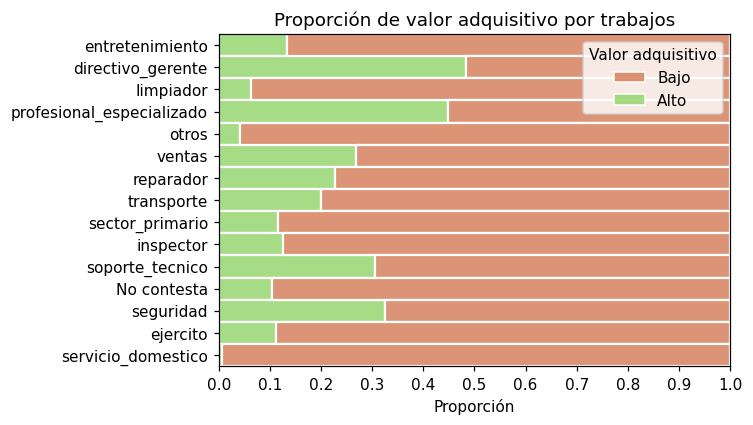

In [26]:
plt.figure(dpi=110)

ax = sns.histplot(
    df,
    y='trabajo',
    hue='tiene_alto_valor_adquisitivo',
    multiple='fill',
    palette= ['#D17049', "#89D15E"],
   edgecolor='white')

ax.set_title('Proporción de valor adquisitivo por trabajos')
ax.set_xlabel("Proporción")
ax.set_ylabel("")

leg = ax.get_legend()
leg.set_title("Valor adquisitivo")
labs = leg.texts
labs[0].set_text("Bajo")
labs[1].set_text("Alto")
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

Bueno...pareciera ser que ser gerente o directivo es el camino. También ser un profesional especializado o dedicarse al sector de la seguridad o el soporte técnico. Veamos de que trabajan los jovenes y los que alguna vez lo fueron

### ¿Hay muchos menores a 30 o mayores a 50 gerentes? ¿Y profesionales?

Veamos que sucede con los trabajos que declaran los menores a 30 años

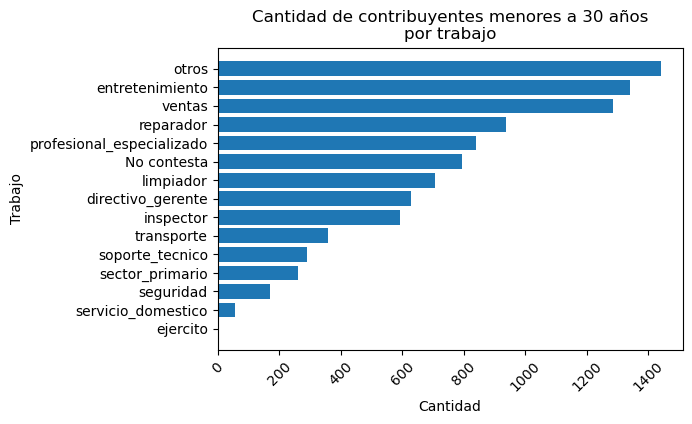

In [27]:
plt.figure(dpi = 100)
jovenes = df[(df.edad < 30)]
jovenes = jovenes['trabajo'].value_counts(ascending=True)


y_pos = np.arange(len(jovenes.index))
plt.barh(y_pos, jovenes.values, align='center')
plt.yticks(y_pos, jovenes.index)
plt.ylabel('Trabajo')
plt.xlabel('Cantidad')
plt.xticks(rotation = 45)
plt.title('Cantidad de contribuyentes menores a 30 años\npor trabajo')
plt.show()

**CONCLUSIón**

Y ahora mas 60

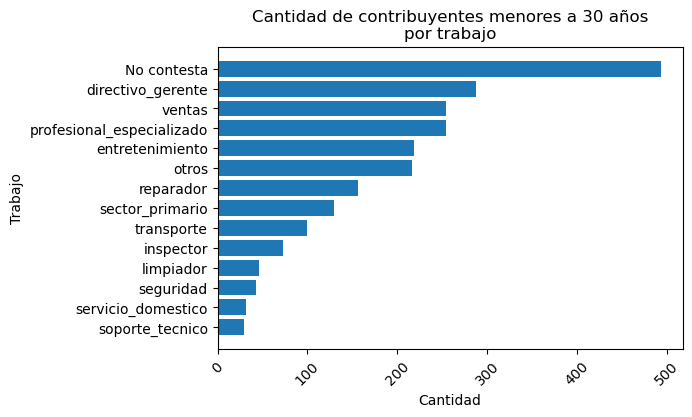

In [28]:
plt.figure(dpi = 100)
jovenes = df[(df.edad > 60)]
jovenes = jovenes['trabajo'].value_counts(ascending=True)


y_pos = np.arange(len(jovenes.index))
plt.barh(y_pos, jovenes.values, align='center')
plt.yticks(y_pos, jovenes.index)
plt.ylabel('Trabajo')
plt.xlabel('Cantidad')
plt.xticks(rotation = 45)
plt.title('Cantidad de contribuyentes menores a 30 años\npor trabajo')
plt.show()

**CONCLUSIÓN**

Aca me parece que iria una conclusión general y decir algo como bueno hablamos de un monton de cosas, hablemos de algo que viene pisando fuerte en los últimos años... el género

# Ellos y Ellas

Es momento de saber como es el género de nuestros queridos contribuyentes

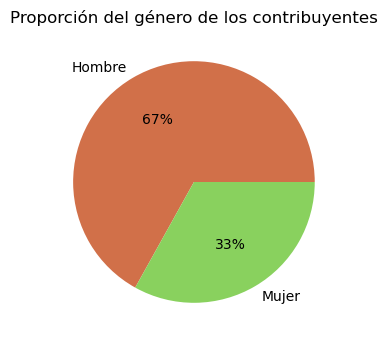

In [29]:
plt.figure(dpi=100)
cantidad_por_genero = df.genero.value_counts(normalize=True)
cantidad_por_genero.plot(kind='pie',labels= ['Hombre', 'Mujer'],colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.title('Proporción del género de los contribuyentes')
plt.ylabel('')
plt.show()



Se observa una mayor cantidad de hombres. Una posible explicación, podria ser que, aún en los tiempos que corren, las mujeres continuan realizando mayormente tareas domesticas no remuneradas que les impide trabajar. Veamos si se evidencian algunas otras desigualdades

## ¿Hay igualdad de Genero en los valores adquisitivos declarados?

Muchas veces se menciona el hecho de que las mujeres suelen tener más obstaculos para llegar a ser mejor remuneradas. Veamos...

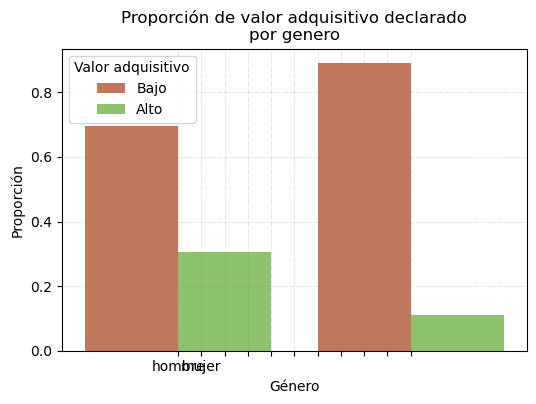

In [30]:
plt.figure(dpi = 100)
colors = ['#D17049', "#89D15E"]


bar_plot = sns.barplot(
    data=df.groupby("genero")
    .tiene_alto_valor_adquisitivo.value_counts(normalize=True)
    .rename("Proporción")
    .reset_index(),
    x='genero',
    y="Proporción",
    hue='tiene_alto_valor_adquisitivo',
    palette=colors,
)
bar_plot.set_xlabel("Género")
bar_plot.set_title("Proporción de valor adquisitivo declarado\npor genero")
bar_plot.set_xticks(np.arange(0,1.1, 0.1))
leg = bar_plot.get_legend()
leg.set_title("Valor adquisitivo")
labs = leg.texts
labs[0].set_text("Bajo")
labs[1].set_text("Alto")



plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)


plt.show()

Como podemos observar, no es para nada equitativa la declaración de alto valor adquisitivo. Osea que no solo hay más hombres, sino que estos tiene mas chances de calificar como de alto valor adquisitivo. ¿Qué es lo que puede llevar a esto?



##  ¿El género influye en las horas trabajadas?

Antes habiamos mencionado que una posibilidad de disparidad en cantidad de contribuyentes hombres y mujeres, era que aún estos tiempos era posible que más mujeres se ocupen solo de tareas domesticas. Pero ¿Y si esta tendencia se mantiene aún en aquellas mujeres que tiene un trabajo remunerado?

<ipython-input-31-613cfa2ad8e1>:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(pf['horas_trabajadas_promedio'])


Text(0, 0.5, 'Horas promedio')

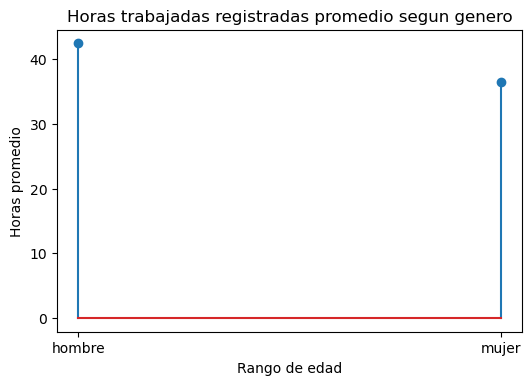

In [31]:
pf = df.groupby('genero').agg(list)
pf['horas_trabajadas_promedio'] = pf['horas_trabajo_registradas'].apply(np.mean)

plt.figure(dpi=100)
plt.stem(pf['horas_trabajadas_promedio'])
plt.title('Horas trabajadas registradas promedio segun genero')
plt.xticks(np.arange(0,2,1),pf.index)
plt.xlabel('Rango de edad')
plt.ylabel('Horas promedio')

**Reordenamos la categoria de 'rol_familiar_registrado' por tener una inconsistencia con el rol 'casado' y 'casada' por separada**

In [32]:
casada_mujer_o_casado_hombre = (df.rol_familiar_registrado == 'casado' ) | (df.rol_familiar_registrado == 'casada') 
df['rol_familiar_registrado'].mask(casada_mujer_o_casado_hombre, 'casado_a', inplace=True)

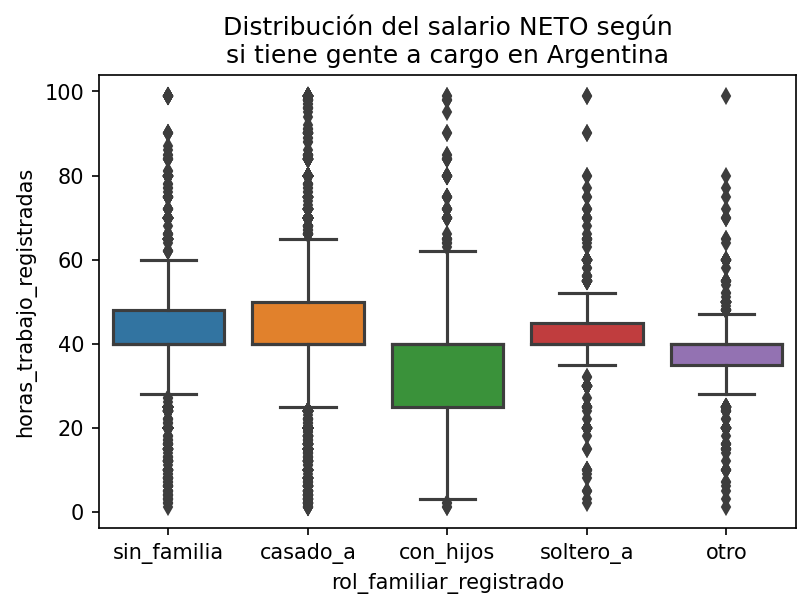

In [33]:
plt.figure(dpi=150)
pf = df[df.genero == 'hombre']
plt.title("Distribución del salario NETO según\nsi tiene gente a cargo en Argentina")
sns.boxplot(
    data=pf,
    y='horas_trabajo_registradas',
    x='rol_familiar_registrado',

)
plt.show()

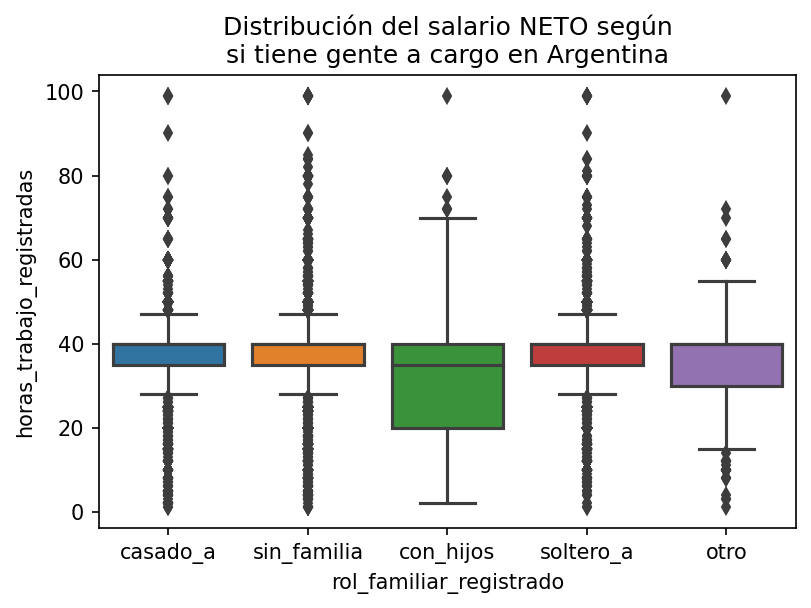

In [34]:
plt.figure(dpi=150)
pf = df[df.genero == 'mujer']
plt.title("Distribución del salario NETO según\nsi tiene gente a cargo en Argentina")
sns.boxplot(
    data=pf,
    y='horas_trabajo_registradas',
    x='rol_familiar_registrado',

)
plt.show()

In [35]:
df[(df.genero == 'hombre') & (df.rol_familiar_registrado == 'con_hijos')].describe()

,anios_estudiados,edad,suma_declarada_bolsa_argentina,horas_trabajo_registradas,tiene_alto_valor_adquisitivo
count,2823.000000,2823.000000,2823.000000,2823.000000,2823.000000
mean,13.319518,24.990790,119.374070,35.227772,0.014878
std,2.062953,7.901183,2220.449214,12.960969,0.121085
min,1.000000,17.000000,-2339.000000,1.000000,0.000000
25%,13.000000,20.000000,0.000000,25.000000,0.000000
50%,13.000000,23.000000,0.000000,40.000000,0.000000
75%,14.000000,28.000000,0.000000,40.000000,0.000000
max,20.000000,90.000000,99999.000000,99.000000,1.000000


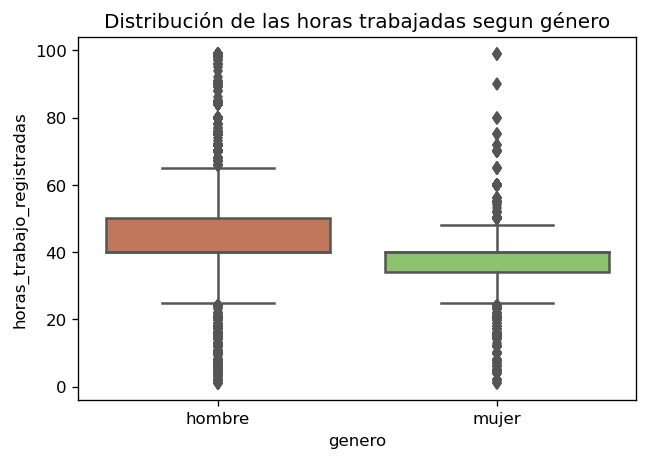

In [36]:
plt.figure(dpi=120)
pf = df[df.estado_marital == 'matrimonio_civil']
plt.title("Distribución de las horas trabajadas segun género")
sns.boxplot(
    data=pf,
    y='horas_trabajo_registradas',
    x='genero',
    palette=['#D17049', "#89D15E"],
)

plt.show()

Ver horas trabajadas de mujeres con hijos, casadas vs hombres con hijos y casados

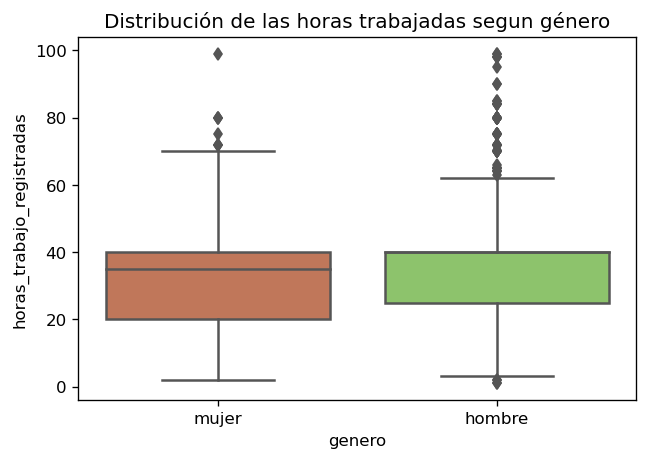

In [37]:
plt.figure(dpi=120)
plt.title("Distribución de las horas trabajadas segun género")
con_hijos = df[(df.rol_familiar_registrado == 'con_hijos')]
sns.boxplot(
    data=con_hijos,
    y='horas_trabajo_registradas',
    x='genero',
    palette=['#D17049', "#89D15E"],
)

plt.show()

## Género y trabajo

In [38]:
(df[df.genero == 'mujer']).trabajo.value_counts(normalize=True)

entretenimiento              0.235540
otros                        0.167115
profesional_especializado    0.140655
ventas                       0.117259
directivo_gerente            0.107604
No contesta                  0.078080
inspector                    0.051063
soporte_tecnico              0.032309
reparador                    0.020611
limpiador                    0.015226
servicio_domestico           0.013091
transporte                   0.008356
seguridad                    0.007056
sector_primario              0.006035
Name: trabajo, dtype: float64

In [39]:
(df[df.genero == 'hombre']).trabajo.value_counts(normalize=True)

reparador                    0.177926
directivo_gerente            0.133410
profesional_especializado    0.120468
ventas                       0.109546
transporte                   0.069160
otros                        0.068609
inspector                    0.066636
entretenimiento              0.056586
limpiador                    0.055346
No contesta                  0.045984
sector_primario              0.042634
soporte_tecnico              0.026618
seguridad                    0.026296
ejercito                     0.000413
servicio_domestico           0.000367
Name: trabajo, dtype: float64

Porcentualmente pareciera que las mujeres no tiene mas problemas para ser profesionales o gerentes. Sera entonces que les apgan menos por los mismos trbaajos?

# Con la democracia se come, se cura y ¿Se educa?


## ¿Los encuestados tienen elevada cantidad de años estudiados?


**Conclusion**

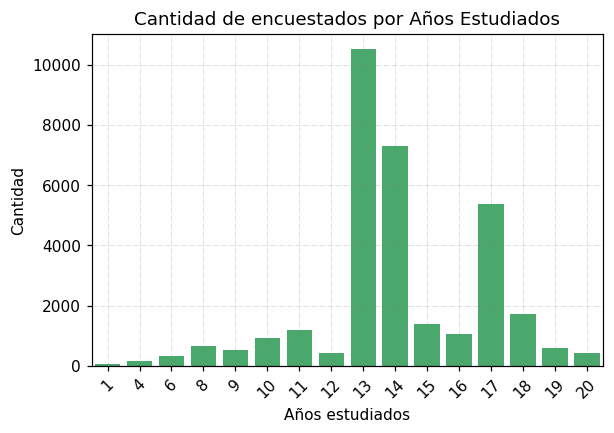

In [40]:
fig, ax = plt.subplots(dpi=110)

sns.countplot(
    x="anios_estudiados",
    data=df,
    color=(0.23, 0.72, 0.41),
    orient= "v",
)
plt.ylabel("Cantidad")
plt.xlabel("Años estudiados")
plt.title("Cantidad de encuestados por Años Estudiados")
plt.xticks(rotation=45)
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()



**CONCLUSION**

## ¿Como son los niveles de educacion alcanzados?

In [41]:
def agrupacion_educacion(categoria):
    if categoria in ['universidad_4_anio','universiada_5_anio','universiada_6_anio']:
        return 'Universitario - (3,6] grado'
    if categoria in ['universidad_1_anio','universidad_2_anio','universidad_3_anio']:
        return 'Universitario - [1,3] grado'
    if categoria in ['1_anio','2_anio','3_anio']:
        return 'Secundario - [1,3] grado'
    if categoria in ['4_anio','5_anio','6_anio']:
        return 'Secundario - (3,6] grado'
    if categoria in ['1-4_grado','5-6_grado']:
        return 'Primaria - [1,6] grado'
    if categoria in ['7-8_grado','9_grado']:
        return 'Primaria - (6,9] grado'
    if categoria in ['preescolar']:
        return 'Jardin'    
    return categoria


df['Educacion alcanzada generalizada distinta'] = df.educacion_alcanzada.apply(agrupacion_educacion)

In [42]:
universitario = 'Universitario'
secundaria = 'Secundaria'
primaria = 'Primaria'
jardin = 'Jardin'

def agrupacion_educacion(educacion_alcanzada):
    return {'universidad_3_anio':universitario, '4_anio':secundaria, '2_anio':secundaria,  'universidad_4_anio':universitario, 
       '9_grado':primaria, '5_anio':secundaria,  'universidad_2_anio':universitario,  'universidad_1_anio':universitario, 
       '7-8_grado':primaria, 'universiada_6_anio':universitario,  'universiada_5_anio':universitario, 
       '5-6_grado':primaria, '1_anio':secundaria,  '1-4_grado':primaria, 'preescolar':jardin, '3_anio':secundaria}[educacion_alcanzada]


df['Educacion alcanzada generalizada'] = df.educacion_alcanzada.apply(agrupacion_educacion)

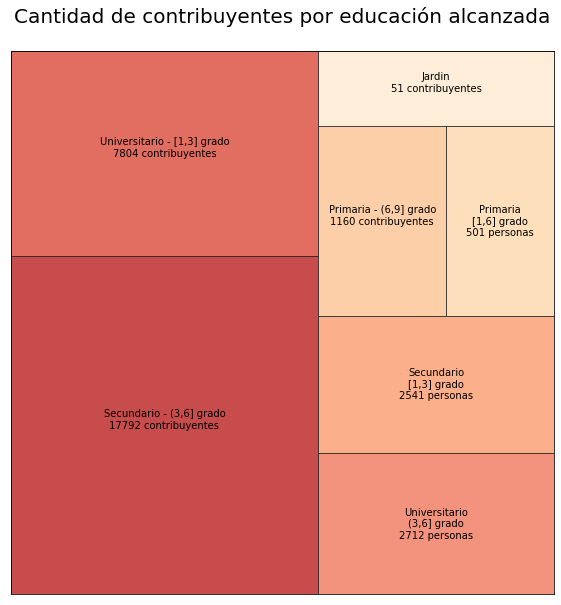

In [43]:
pivited = pd.pivot_table(
    df,
    index='Educacion alcanzada generalizada distinta',
    aggfunc={
        'Educacion alcanzada generalizada distinta': 'count',
    },
)
padding = 3000 # la buena técnica de relleno, nada le gana
df2 = pivited.rename(columns={'Educacion alcanzada generalizada distinta': 'Cantidad'})
df2.sort_values(by="Cantidad", ascending=False, inplace=True)
df2_modificated = df2.copy()
df2_modificated.Cantidad = df2_modificated.Cantidad+padding
df2_modificated.loc[(df2_modificated.index =='Secundario - (3,6] grado')] = df2_modificated.loc[(df2_modificated.index =='Secundario - (3,6] grado')] - padding


colors = ['#00aae4', '#5ab8e9', '#84c6ed', '#a6d4f2', '#c5e2f6', '#e2f0fb', '#e2f0fb']
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, aspect="equal")
labels = ["%s\n%d contribuyentes\n" % (label) for label in zip(df2.index, df2.Cantidad)]
#labels[6]=' '

labels[5] = "Primaria\n[1,6] grado\n%d personas" % (df2["Cantidad"]["Primaria - [1,6] grado"])
labels[3] = "Secundario\n[1,3] grado\n%d personas" % (df2["Cantidad"]["Secundario - [1,3] grado"])
labels[2] = "Universitario\n(3,6] grado\n%d personas" % (df2["Cantidad"]["Universitario - (3,6] grado"])

ax = squarify.plot(df2_modificated.Cantidad, alpha=.7, label=labels,ax=ax,color=(sns.color_palette("OrRd_r", 7)), bar_kwargs=dict(linewidth=1, edgecolor="#222222"))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Cantidad de contribuyentes por educación alcanzada\n", fontsize=20)
plt.show()

**Conclusión**

## ¿Se graduan la misma proporción de generos?

### Opcion vieja:

<Figure size 900x600 with 0 Axes>

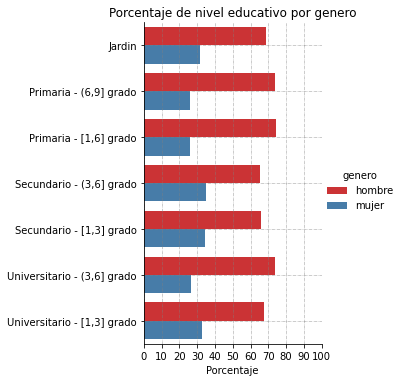

In [44]:
plt.figure(dpi=150)

y,x = 'genero', 'Educacion alcanzada generalizada distinta'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Porcentaje').reset_index()
sns.catplot(y=x,x='Porcentaje',hue=y,kind='bar',data=df1,  palette="Set1")

plt.ylabel("")
plt.title("Porcentaje de nivel educativo por genero")
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.8)
plt.xticks(np.arange(0,110, 10))

plt.show()



### Opcion nueva: (mostrar separadamete dos treemap)

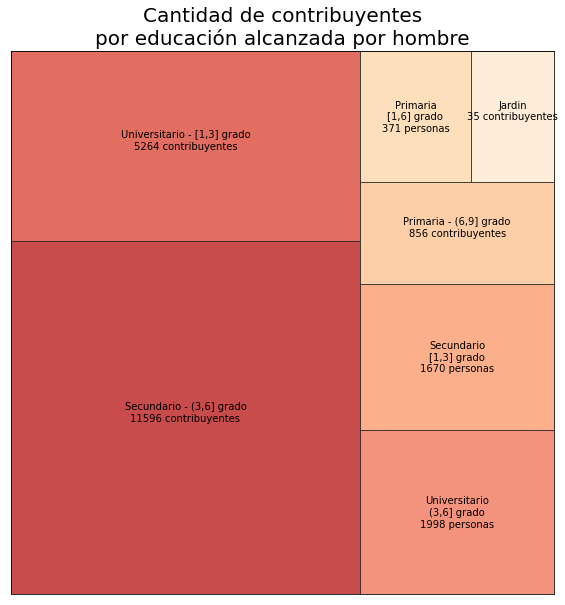

In [45]:
def graficar_treemap_educacion_por_genero(genero,color):

    pivited = pd.pivot_table(
        data=df[df.genero==genero],
        index='Educacion alcanzada generalizada distinta',
        aggfunc={
            'Educacion alcanzada generalizada distinta': 'count',
        },
    )
    padding = 1000 # la buena técnica de relleno, nada le gana
    df2 = pivited.rename(columns={'Educacion alcanzada generalizada distinta': 'Cantidad'})
    df2.sort_values(by="Cantidad", ascending=False, inplace=True)
    df2_modificated = df2.copy()
    df2_modificated.Cantidad = df2_modificated.Cantidad+padding
    df2_modificated.loc[(df2_modificated.index =='Secundario - (3,6] grado')] = df2_modificated.loc[(df2_modificated.index =='Secundario - (3,6] grado')] - padding


    colors = ['#00aae4', '#5ab8e9', '#84c6ed', '#a6d4f2', '#c5e2f6', '#e2f0fb', '#e2f0fb']
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, aspect="equal")
    labels = ["%s\n%d contribuyentes\n" % (label) for label in zip(df2.index, df2.Cantidad)]
    #labels[6]=' '

    labels[5] = "Primaria\n[1,6] grado\n%d personas" % (df2["Cantidad"]["Primaria - [1,6] grado"])
    labels[3] = "Secundario\n[1,3] grado\n%d personas" % (df2["Cantidad"]["Secundario - [1,3] grado"])
    labels[2] = "Universitario\n(3,6] grado\n%d personas" % (df2["Cantidad"]["Universitario - (3,6] grado"])

    ax = squarify.plot(df2_modificated.Cantidad, alpha=.7, label=labels,ax=ax,color=(sns.color_palette(color, 7)), bar_kwargs=dict(linewidth=1, edgecolor="#222222"))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Cantidad de contribuyentes por educación alcanzada\n", fontsize=20)

    title = "Cantidad de contribuyentes\npor educación alcanzada por " + genero
    ax.set_title(title, fontsize=20)
    plt.show()

graficar_treemap_educacion_por_genero("hombre","OrRd_r")

Veamos en el caso de las mujeres


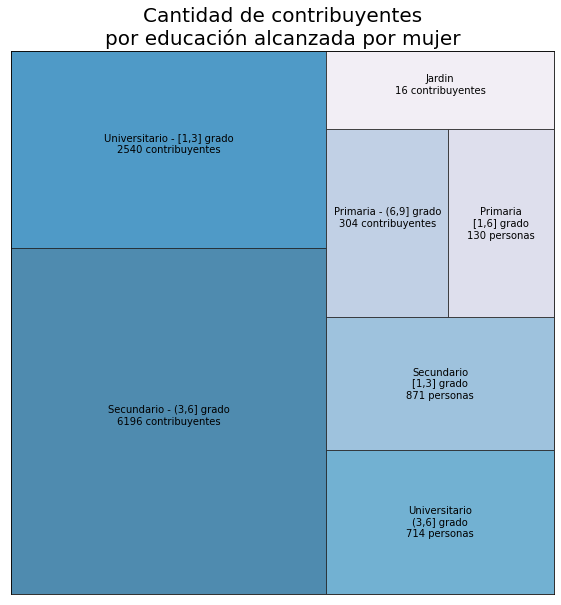

In [46]:
graficar_treemap_educacion_por_genero("mujer","PuBu_r")

Aca yo dividiria por género y mostraria la educacion asi sacamos conclusiones. El grafico asi como esta no dice demasiado teniendo en cuenta que hay mas hombres que mujeres

## ¿Hay relación con el valor adquisitivo segun los años estudiados y nivel educativo alcanzado?

In [47]:
def agrupacion_anios_estudiados(categoria):
    if categoria in np.arange(1,5).tolist():
        return '(0,4]'
    if categoria in np.arange(4,8).tolist():
        return '(4,7]'
    if categoria in np.arange(7,11).tolist():
        return '(7,10]'
    if categoria in np.arange(10,16).tolist():
        return '(10,15]'
    if categoria in np.arange(16,21).tolist():
        return '(15,20]'
    return categoria


df['Anios estudiados generalizada'] = df.anios_estudiados.apply(agrupacion_anios_estudiados)

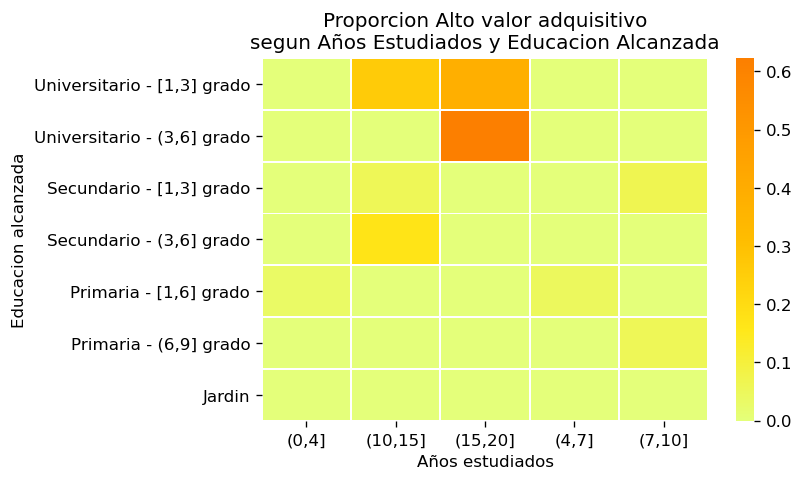

In [48]:
plt.figure(dpi=120)
pivoted_years = pd.pivot_table(
    data = df, 
    index ='Educacion alcanzada generalizada distinta', 
    values = 'tiene_alto_valor_adquisitivo', 
    columns = 'Anios estudiados generalizada',
)
pivoted_years.sort_index(ascending =  False, inplace = True)
pivoted_years = pivoted_years.replace(np.nan,0)
g = sns.heatmap(pivoted_years, cmap="Wistia", linewidths=.5)
g.set_ylabel("Educacion alcanzada")
g.set_xlabel("Años estudiados")
g.set_title("Proporcion Alto valor adquisitivo\nsegun Años Estudiados y Educacion Alcanzada")

plt.show()

**Conclusión**

# Buscando al lobo de Wall Street Argentino

Cuando se tiene tiempo libre, cuando se dispone de capital o a veces por mera curiosidad, los trabajadores recurren a la bolsa a ver si se puede ganar algo más de dinero del que les da su actividad principal. Veamos que proporción de contribuyentes operan en la bolsa Argentina. Vamos a tener en cuenta que es raro que quién opere en este tipo de activo financiero tenga un balance que le de justo cero, por lo que consideraremos que estos constribuyentes no operan en la bolsa

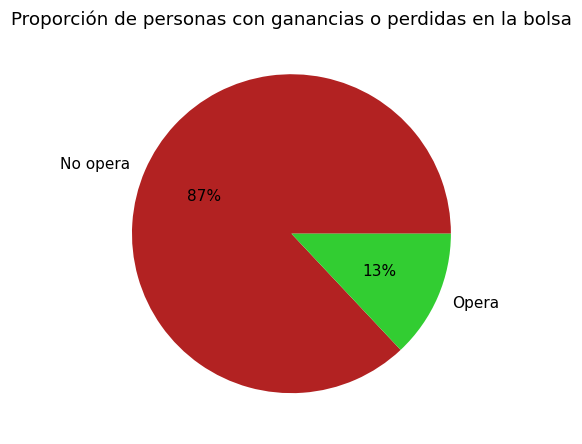

In [49]:
plt.figure(figsize=(6.4, 4.8), dpi=110)
plt.title('Proporción de personas con ganancias o perdidas en la bolsa')
plt.pie((df['suma_declarada_bolsa_argentina'] != 0).value_counts(), labels= ['No opera', 'Opera'], colors=["firebrick",'limegreen'],autopct='%1.0f%%')
plt.ylabel('')
plt.show()

El gráfico es concluyente, el 13% de los contribuyentes del dataset opera en la bolsa

## ¿Qué tal le va a la gente inviertiendo en la bolsa?

Amada por algunos y defenestrada por otros, la inversión en la bolsa puede ser tocar el cielo con las manos o el comienzo de la bancarrota. Observemos

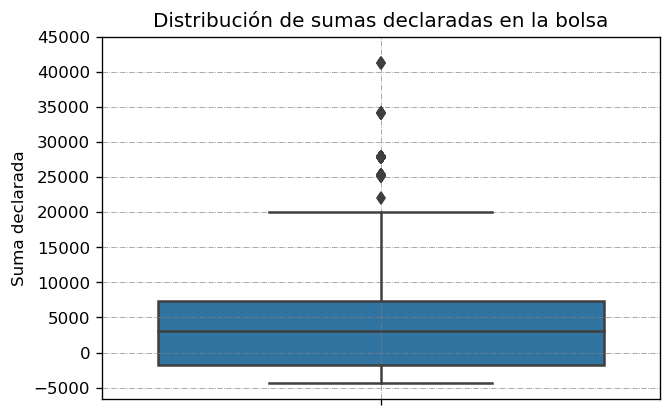

In [50]:
plt.figure(dpi=120)
outlier_quitado = (df.suma_declarada_bolsa_argentina != 99999)
los_que_operan = df[(df.suma_declarada_bolsa_argentina != 0) & outlier_quitado]
plt.title("Distribución de sumas declaradas en la bolsa")
sns.boxplot(
    data=los_que_operan,
    y='suma_declarada_bolsa_argentina',
)
plt.yticks(np.arange(-5000,50000,5000))
plt.ylabel("Suma declarada")
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.8)

plt.show()

En primer lugar, lo que se observa es que no hay grandisimas ganancias (si los valores estan en pesos) por parte de los bolseros. En segundo Lugar, tampoco pareciera haber muchas perdidas. Si se pueden observar algunos casos excepcionales (outliers) de personas que realmente logran triunfar con sus inversiones

## ¿Hay algún estado marital que favorezca el interés por operar en la bolsa?

Por nuestra propia experiencia, muchos solteros/as que al no estar   acuden a la bolsa al no tener en donde invertir sus ahorros (y además poder ahorrar más). Veamos si esto es asi

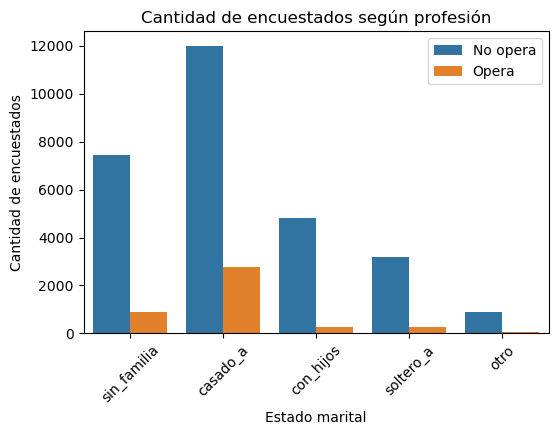

In [51]:
df['declaro_actividad_en_bolsa'] = df['suma_declarada_bolsa_argentina'] != 0
df['declaro_actividad_en_bolsa'].replace(False,0)

plt.figure(dpi = (100))
sns.countplot(
   data=df, x='rol_familiar_registrado', hue='declaro_actividad_en_bolsa'
)
plt.legend(labels=['No opera','Opera'])
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Estado marital")
plt.title("Cantidad de encuestados según profesión")
plt.xticks(rotation=45)
plt.show()



plt.show()

Contrariamente a lo pensado, el mayor porcentaje de inversores en la bolsa se da en gente casada. Sin embargo, al momento de observar a quienes tienen hijos, se ve una disminución muy fuerte de gente inviertiendo en la bolsa. Esto puede deberse a que quizás, la gente prefiere tener el dinero ahorrado, sin generar interés pero también sin generar una posible perdida.

## Tener alto valor adqusitivo ¿Sinónimo de operar en la bolsa?

Dijimos en la introducción a este segmento, que mucha gente recurre a la bolsa por tener capacidad de ahorro y no querer tener inmovilizado ese dinero. Grafiquemos

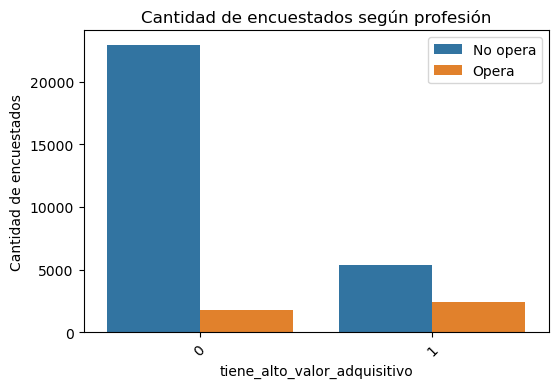

In [52]:
df['declaro_actividad_en_bolsa'] = df['suma_declarada_bolsa_argentina'] != 0
df['declaro_actividad_en_bolsa'].replace(False,0)

plt.figure(dpi = (100))
sns.countplot(
   data=df, x='tiene_alto_valor_adquisitivo', hue='declaro_actividad_en_bolsa'
)
plt.legend(labels=['No opera','Opera'])
plt.ylabel("Cantidad de encuestados")
plt.title("Cantidad de encuestados según profesión")
plt.xticks(rotation=45)
plt.show()



plt.show()

Se observa una mayor tendencia a operar en la bolsa por parte de contribuyentes de altos ingresos, más del 30% tiene alguna suma declarada. El número desciende drásticamente para contribuyentes de bajos ingresos. ¿Y si una de las claves del éxito esta en las acciones? Prosigamos 

### Tienen alto poder adquisitivo y operan en la bolsa ¿Ganan?

Veamos la distribución

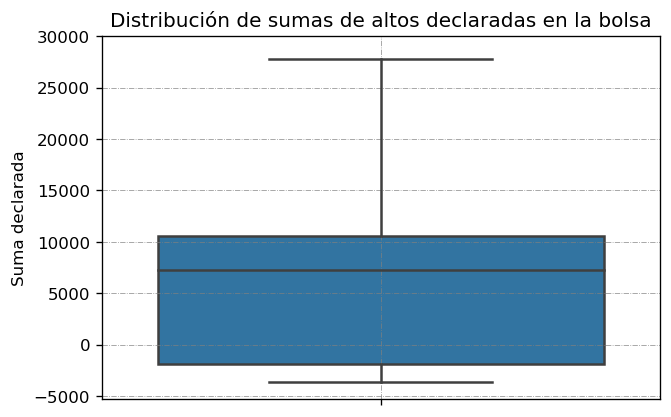

In [53]:
plt.figure(dpi=120)
outlier_quitado = (df.suma_declarada_bolsa_argentina != 99999)

los_que_operan_y_alto = df[(df.suma_declarada_bolsa_argentina != 0) & (df.tiene_alto_valor_adquisitivo == 1) & outlier_quitado]
plt.title("Distribución de sumas de altos declaradas en la bolsa")
sns.boxplot(
    data=los_que_operan_y_alto,
    y='suma_declarada_bolsa_argentina',
)
plt.yticks(np.arange(-5000,35000,5000))
plt.ylabel("Suma declarada")
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.8)

plt.show()

Notable, un alto porcentaje de quienes tienen altos ingresos ganan en la bolsa. Pero bueno, esto en sí no nos dice mucho, veamos la otra cara de la moneda


### Tienen bajo poder adquisitivo y operan en la bolsa ¿Pierden?

Grafiquemos

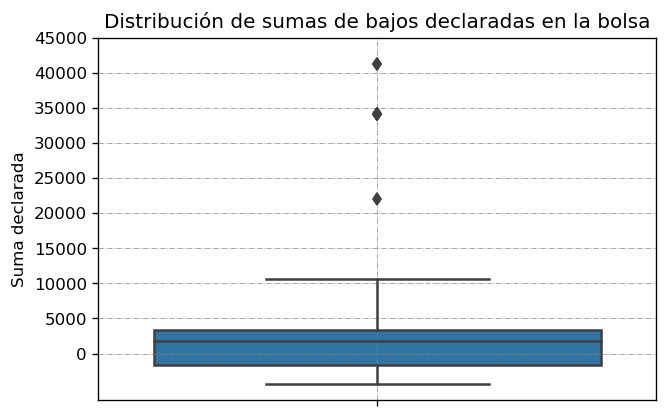

In [54]:
plt.figure(dpi=120)
los_que_operan_y_bajo = df[(df.suma_declarada_bolsa_argentina != 0) & (df.tiene_alto_valor_adquisitivo == 0)]
plt.title("Distribución de sumas de bajos declaradas en la bolsa")
sns.boxplot(
    data=los_que_operan_y_bajo,
    y='suma_declarada_bolsa_argentina',
)
plt.yticks(np.arange(0,50000,5000))
plt.ylabel("Suma declarada")
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.8)

plt.show()

Es notable, la gran diferencia se ve en los montos que ganan los de bajo poder adquisitivo. Basta comparar el máximo aquí con el del gráfico anterior. Mención especial a unos pocos outliers

Bueno, hasta aquí con la bolsa. Ya hablamos de varias cosas y si bien en el camino fuimos recolectando información al respecto, llego la hora de ir al grano

# Los ricos no piden permiso

Venimos de identificar una interesante relación entre el alto valor adquisitivo y la bolsa. Ya habiamos visto antes la influencia de la edad, del género, de la educación e incluso los trabajos que son propensos a tener más dinero. Profundizemos

## Sector público vs Sector privado ¿Afecta la categoría de trabajo al nivel de ingresos?

Algunos sostienen que en el Estado se gana más, pero hemos escuchado que el sector privado aún se mantiene fuerte. ¿Será mejor estar en relación de dependencia? ¿O mejor ser monotributista/responsable inscripto? Grafiquemos, teniendo en cuenta también el trabajo

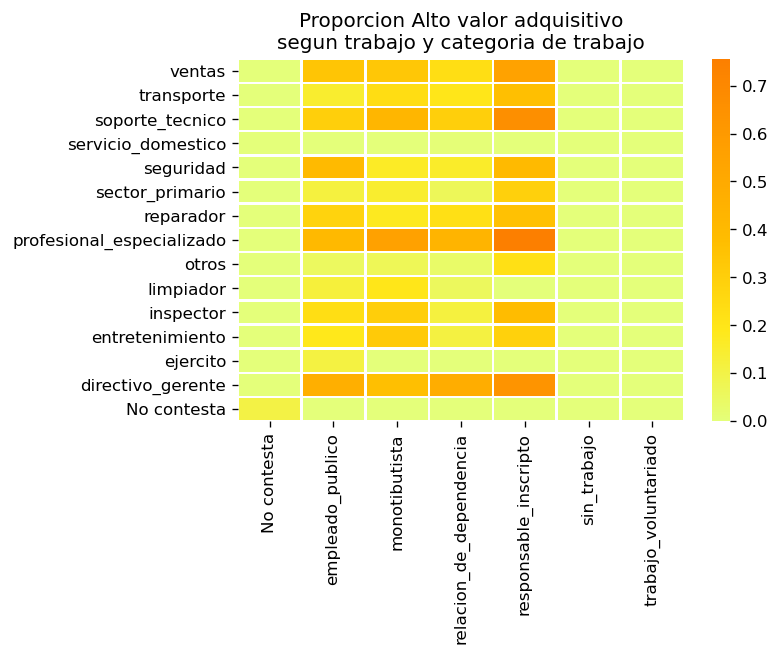

In [55]:
plt.figure(dpi=120)
pivoted_years = pd.pivot_table(
    data = df, 
    index ='trabajo', 
    values = 'tiene_alto_valor_adquisitivo', 
    columns = 'categoria_de_trabajo',
)
pivoted_years.sort_index(ascending =  False, inplace = True)
pivoted_years = pivoted_years.replace(np.nan,0)
g = sns.heatmap(pivoted_years, cmap="Wistia", linewidths=.9)
g.set_ylabel("")
g.set_xlabel("")
g.set_title("Proporcion Alto valor adquisitivo\nsegun trabajo y categoria de trabajo")

plt.show()

La categoria que pareciera presentar más contribuyentes de altos ingresos pareciera ser responsable inscripto

## valor adquisitivo y religion

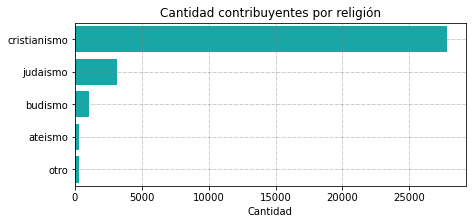

In [56]:
f, ax = plt.subplots(figsize=(7, 3))
g = sns.countplot(y="religion", data=df, color="c")
g.set_ylabel("")
g.set_xlabel("Cantidad")
plt.xticks(np.arange(0,30000,5000))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.8)
plt.title("Cantidad contribuyentes por religión")
plt.show()

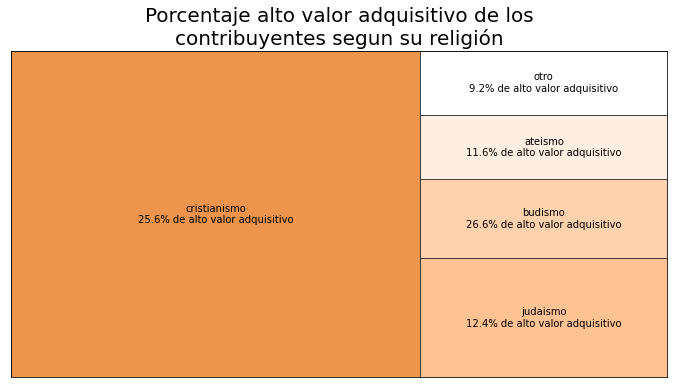

In [57]:

pivited_religion = pd.pivot_table(
    df,
    index='religion',
    aggfunc={
        'religion': 'count',
        'tiene_alto_valor_adquisitivo': 'mean',
    },
)
padding = 3000 # la buena técnica de relleno, nada le gana
df2 = pivited_religion.rename(columns={'religion': 'Cantidad'})
df2.sort_values(by="Cantidad", ascending=False, inplace=True)
df2_modificated = df2.copy()
df2_modificated.Cantidad = df2_modificated.Cantidad+padding
df2_modificated.loc[(df2_modificated.index =='cristianismo')] = df2_modificated.loc[(df2_modificated.index =='cristianismo')] - padding

colors = [ '#e66800', '#ffa865', '#ffbe8b', '#ffe9d8', '#ffffff']
fig = plt.figure(figsize=(40, 6))
ax = fig.add_subplot(131)
labels = ["%s\n%0.1f%% de alto valor adquisitivo" % (label) for label in zip(df2.index, df2.tiene_alto_valor_adquisitivo*100)]

#labels[0]=' '

#labels[5] = "Primaria\n[1,6] grado\n%d personas" % (df2["Cantidad"]["Primaria - [1,6] grado"])
#labels[3] = "Secundario\n[1,3] grado\n%d personas" % (df2["Cantidad"]["Secundario - [1,3] grado"])
#labels[2] = "Universitario\n(3,6] grado\n%d personas" % (df2["Cantidad"]["Universitario - (3,6] grado"])

ax = squarify.plot(df2_modificated.Cantidad, alpha=.7, label=labels,ax=ax,color=colors, bar_kwargs=dict(linewidth=1, edgecolor="#222222"))
                
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Porcentaje alto valor adquisitivo de los\ncontribuyentes segun su religión", fontsize=20)
plt.show()

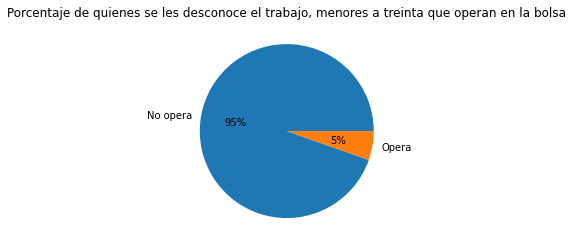

In [58]:
menores_a_treinta = dataset_sin_contestar[dataset_sin_contestar['edad'] <= 30]
porcentaje_que_opera = (menores_a_treinta['suma_declarada_bolsa_argentina'] != 0).value_counts(normalize=True)
porcentaje_que_opera.plot(kind='pie',autopct='%1.0f%%',labels = ['No opera','Opera'])
plt.title('Porcentaje de quienes se les desconoce el trabajo, menores a treinta que operan en la bolsa')
plt.ylabel('')
plt.show()


## ¿Impacta el valor adquisitivo si se encuentra en matrimonio civil?

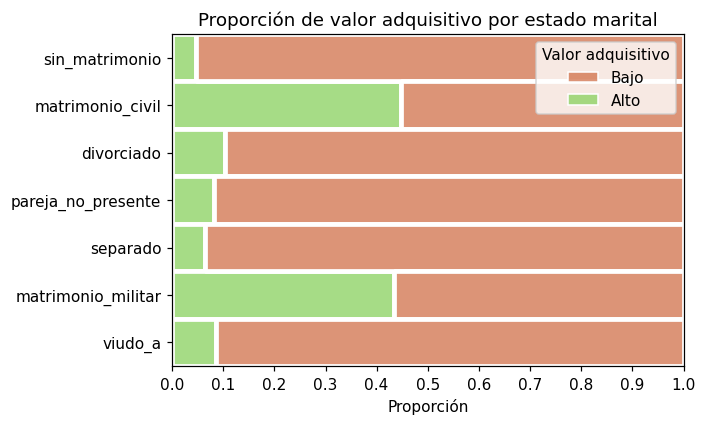

In [59]:
plt.figure(dpi=110)

ax = sns.histplot(
    df,
    y='estado_marital',
    hue='tiene_alto_valor_adquisitivo',
    multiple='fill', # {"layer", "dodge", "stack", "fill"}
    palette= ['#D17049', "#89D15E"],
    edgecolor='white')

ax.set_title('Proporción de valor adquisitivo por estado marital')
ax.set_xlabel("Proporción")
ax.set_ylabel("")

leg = ax.get_legend()
leg.set_title("Valor adquisitivo")
labs = leg.texts
labs[0].set_text("Bajo")
labs[1].set_text("Alto")
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

## valor y horas trabajadas

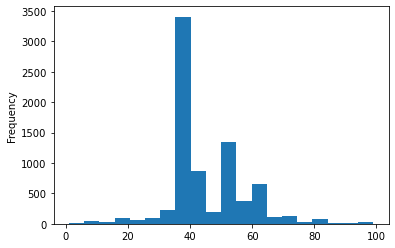

In [60]:
altos = df[df.tiene_alto_valor_adquisitivo == 1]
altos['horas_trabajo_registradas'].plot(kind='hist',bins=20)

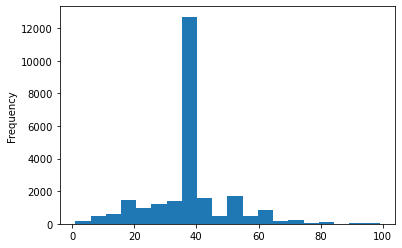

In [61]:
bajos = df[df.tiene_alto_valor_adquisitivo == 0]
bajos['horas_trabajo_registradas'].plot(kind='hist',bins=20)

## valor y casados

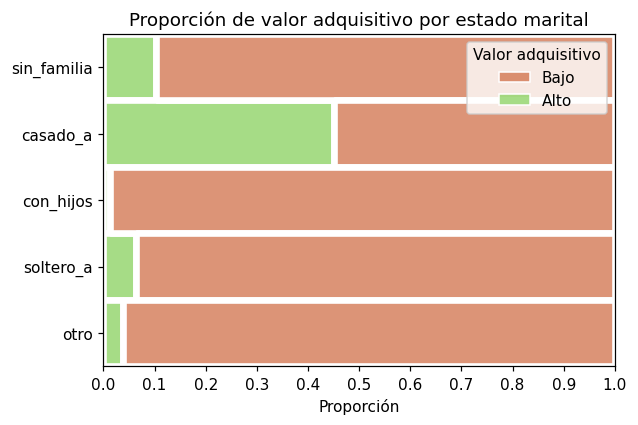

In [62]:
plt.figure(dpi=110)

ax = sns.histplot(
    df,
    y='rol_familiar_registrado',
    hue='tiene_alto_valor_adquisitivo',
    multiple='fill',
    palette= ['#D17049', "#89D15E"],
    edgecolor='white')

ax.set_title('Proporción de valor adquisitivo por estado marital')
ax.set_xlabel("Proporción")
ax.set_ylabel("")

leg = ax.get_legend()
leg.set_title("Valor adquisitivo")
labs = leg.texts
labs[0].set_text("Bajo")
labs[1].set_text("Alto")
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

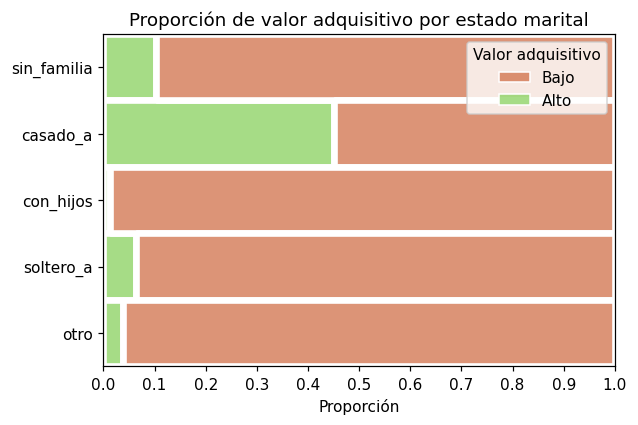

In [63]:
plt.figure(dpi=110)
pf = df[df.trabajo == 'gerente_directivo']
ax = sns.histplot(
    df,
    y='rol_familiar_registrado',
    hue='tiene_alto_valor_adquisitivo',
    multiple='fill',
    palette= ['#D17049', "#89D15E"],
    edgecolor='white')

ax.set_title('Proporción de valor adquisitivo por estado marital')
ax.set_xlabel("Proporción")
ax.set_ylabel("")

leg = ax.get_legend()
leg.set_title("Valor adquisitivo")
labs = leg.texts
labs[0].set_text("Bajo")
labs[1].set_text("Alto")
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

## valor y educacion

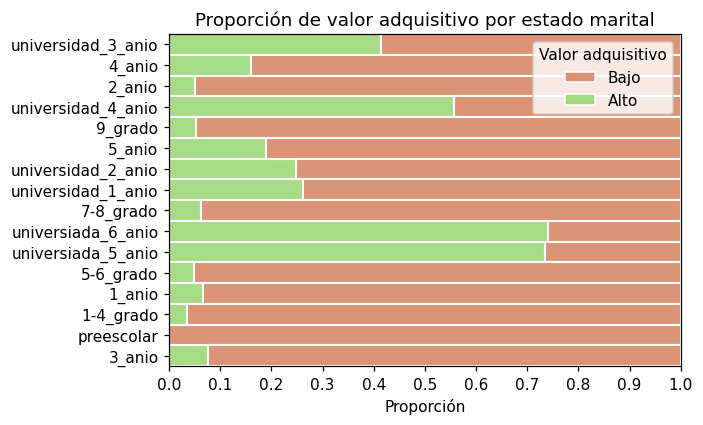

In [64]:
plt.figure(dpi=110)

ax = sns.histplot(
    df,
    y='educacion_alcanzada',
    hue='tiene_alto_valor_adquisitivo',
    multiple='fill',
    palette= ['#D17049', "#89D15E"],
    edgecolor='white')

ax.set_title('Proporción de valor adquisitivo por estado marital')
ax.set_xlabel("Proporción")
ax.set_ylabel("")

leg = ax.get_legend()
leg.set_title("Valor adquisitivo")
labs = leg.texts
labs[0].set_text("Bajo")
labs[1].set_text("Alto")
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

## valor y categoria trabajo

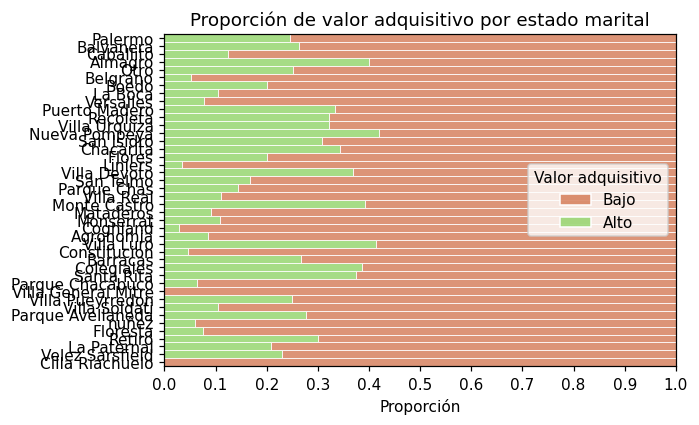

In [65]:
plt.figure(dpi=110)

ax = sns.histplot(
    df,
    y='barrio',
    hue='tiene_alto_valor_adquisitivo',
    multiple='fill',
    palette= ['#D17049', "#89D15E"],
    edgecolor='white')

ax.set_title('Proporción de valor adquisitivo por estado marital')
ax.set_xlabel("Proporción")
ax.set_ylabel("")

leg = ax.get_legend()
leg.set_title("Valor adquisitivo")
labs = leg.texts
labs[0].set_text("Bajo")
labs[1].set_text("Alto")
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

#  Baseline

* A partir de todo el análisis anterior, construir el código baseline que se va a usar para la
primera ronda de campaña digital. Fundamentar el código basándose en las conclusiones de los
anteriores puntos.

* La función baseline debe llamarse baseline(X: pd.DataFrame) -> List[int].
    * la cual debe recibir un pandas dataframe producido de la lectura del archivo de testeo original y devolver una lista con las predicciones (1 para si es de altos ingresos, 0 para si es de bajos ingresos)


In [66]:
df_cleaned = pd.read_csv("fiufip_dataset.csv")

In [67]:
def baseline(df: pd.DataFrame): #-> List[int]
    range_age = ((df['edad'] >= 30) & (df['edad'] <= 50))
    education = (((df.educacion_alcanzada == 'universidad_4_anio') | (df.educacion_alcanzada == 'universidad_5_anio') |  (df.educacion_alcanzada == 'universidad_6_anio') )
                 & ((df.anios_estudiados == 15) |  (df.anios_estudiados == 16) | (df.anios_estudiados == 17) | (df.anios_estudiados == 18) | (df.anios_estudiados == 19) |( df.anios_estudiados ==  20)))
    bolsa = df.ganancia_perdida_declarada_bolsa_argentina > 0
    trabajo = (df.trabajo == 'profesional_especializado') #| (df.trabajo == 'directivo_gerente')
    responsable_inscripto = df.categoria_de_trabajo == 'responsable_inscripto'
    no_judio = df.religion != 'judaismo'   
    predict_final =  (trabajo & range_age % responsable_inscripto & bolsa & no_judio ).astype(np.ubyte)
    return predict_final# 77 78 74
    
df_prediction = baseline(df_cleaned)
print('Accuracy:', accuracy_score(df_cleaned.tiene_alto_valor_adquisitivo, df_prediction).round(10))

Accuracy: 0.7591904426


In [68]:
responsable  = df.categoria_de_trabajo == 'responsable_inscripto'
pro = df.trabajo == 'profesional_especializado'
ventas = df.trabajo == 'ventas'
soporte_tecnico = df.trabajo == 'soporte_tecnico'
hombre = df.genero == 'hombre'
bolsa = df.suma_declarada_bolsa_argentina > 5000# aca la clave
gerente = df.trabajo == 'gerente_directivo'
uni =  (df.educacion_alcanzada == 'universidad_6_anio')
matrimonio_civil = df.estado_marital == 'matrimonio_civil'
no_judio = df.religion != 'judaismo'
monotributista  = df.categoria_de_trabajo == 'monotributista'
horas_trabajadas = df.horas_trabajo_registradas
edad = (df.edad < 50) & (df.edad > 30)
no_bolsa = df.suma_declarada_bolsa_argentina == 0
anios = df.anios_estudiados > 17
anios2 = (df.anios_estudiados > 15) 
horas = df.horas_trabajo_registradas > 80
cristiano = df.religion == 'cristianismo'

asd = (bolsa | (anios & hombre) | (hombre & (responsable | uni) & (pro | ventas )))  # 81,6
asd.replace(True,1)
asd2 = bolsa 
print('Accuracy:', accuracy_score(df_cleaned.tiene_alto_valor_adquisitivo, asd2).round(10) * 100)

Accuracy: 80.04668161000001
